<a href="https://colab.research.google.com/github/echou024/ImageClassificationOnHandwrittenDigitsMulticlassClassification/blob/main/ImageClassificationOnHandwrittenDigitsMulticlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
Performs image classification on a handwritten digits dataset using a two-layer neural network with loss functions, gradients, optimizers. This method uses Multiclass classification.


We will use [MNIST](https://en.wikipedia.org/wiki/MNIST_database) handwritten digits dataset. The dataset consists 10 handwritten digits (0,1,...,9).
The training data consists of 60000 images of size $28 \times 28$ pixels; the test data consists of 10000 images.

We will use the functionality of Pandas (https://pandas.pydata.org/), Matplotlib (https://matplotlib.org/), and Numpy (http://www.numpy.org/).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# make sure you import here everything else you may need

11490434/11490434 [==============================] - 0s 0us/step
Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


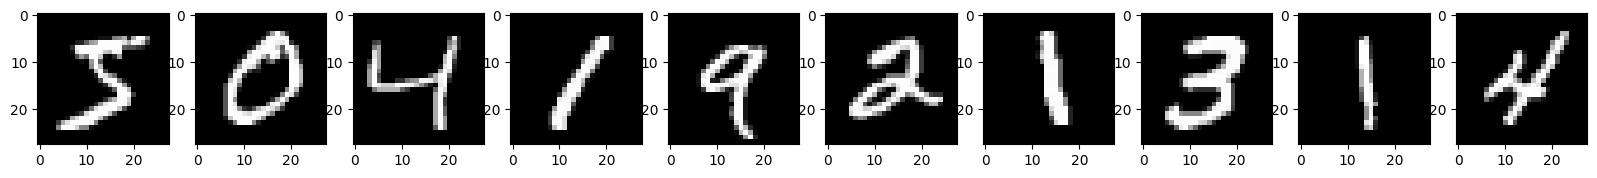

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print('Training data shape:',x_train.shape)
print('Test data shape:',x_test.shape)

n_img=10
plt.figure(figsize=(n_img*2,2))
plt.gray()
for i in range(n_img):
    plt.subplot(1,n_img,i+1)
    plt.imshow(x_train[i])
plt.show()

We will be vectorizing the training and test images. So, the size of each vector will be 784.

In [ ]:
x_train=x_train.reshape(x_train.shape[0],-1)
x_test=x_test.reshape(x_test.shape[0],-1)

print('Training data shape after reshaping:',x_train.shape)
print('Test data shape after reshaping::',x_test.shape)

Training data shape after reshaping: (60000, 784)
Test data shape after reshaping:: (10000, 784)


Multiclass classification:

Now we will build a classifier to separate all the digits. For this purpose, we will only change the last layer and the loss.


Instead of using a single output, we will provide 10 outputs; and instead of using a binary cross entropy loss, we will use mutli-class cross entropy loss.

In multinomal logistic regression (aka softmax regression), we define the posterior probability of label $y \in \{0,\ldots, K-1\}$ as


$$p(y = c | \mathbf{x}) = \frac{\exp(\mathbf{w}_c^T\mathbf{x})}{\sum_{k=1}^K \exp(\mathbf{w}_k^T\mathbf{x})} = \mathbf{p}_c.$$

In other words, last layer of the network provides a probability vector $\mathbf{p} \in \mathbb{R}^K$, such that each $0 \le \mathbf{p}_c \le 1$ and $\sum_c \mathbf{p}_c = 1$.

### Softmax function:

Let us first define the softmax function, which is a multinomal extension of the sigmoid function that maps a vector of length $K$ to a probability vector.

We can define ```softmax``` function on a vector $\mathbf{z} \in \mathbb{R}^K$ as $\mathbf{p} = \text{softmax}(\mathbf{z})$:

$$\mathbf{p}_c(\mathbf{z}) = \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)}$$



In [ ]:
def softmax(Z):
    # Z -- K x N numpy.ndarray, K is the number of classes, N is the number of samples
    # TODO
    # your code goes here...

    expZ = np.exp(Z)

    probs = expZ / expZ.sum(axis=0, keepdims=True)

    return probs

We have to note that the numerical range of floating point numbers in numpy is limited. For `float64` the upper bound is $10^{308}$. For exponential, its not difficult to overshoot that limit, in which case python returns `nan`.

To make our softmax function numerically stable, we simply normalize the values in the vector, by multiplying the numerator and denominator with a constant `C` as

\begin{align*}
\mathbf{p}_c  &= \frac{\exp(\mathbf{z}_c)}{\sum_{k=1}^K \exp(\mathbf{z}_k)} \\
& = \frac{C\exp(\mathbf{z}_c)}{C\sum_{k=1}^K \exp(\mathbf{z}_k)}\\
& = \frac{\exp(\mathbf{z}_c + \log C)}{\sum_{k=1}^K \exp(\mathbf{z}_k + \log C)}.
\end{align*}

We can choose an arbitrary value for `log(C)` term, but generally `log(C) = −max(z)` is chosen


### Multiclass cross entropy loss function:

We will minimize the cross entropy loss. You will use the true labels and predicted labels of a batch of N samples.

The multi-class cross entropy loss for $i^{th}$ sample can be written as
$$Loss_i = -\sum_c \mathbf{1}(y_i = c) \log \mathbf{p}_c $$
where $y_i$ is the true label and

$$\mathbf{1}(y_i = c) = \begin{cases} 1 & y_i =c \\ 0 & \text{otherwise} \end{cases}$$
is an indicator function.

We can find the average loss for a batch of N samples as $Loss=\frac{1}{N}\sum_{i=1}^{N} Loss_i$.


In [ ]:
def MultiClassCrossEntropyLoss(Y_true, probs):

  # TODO
  # Write your code here

  # probs -- K x N array
  # Y_true -- 1 x N array
  # loss --  sum Loss_i over N samples

  total_loss = 0

  # Iterate over each sample in the batch
  for i in range(Y_true.shape[0]):
    # Get the true label for the current sample
    true_label = Y_true[i]

    # Calculate the loss for the current sample
    loss_i = -np.log(probs[true_label, i])

    # Add the loss for the current sample to the total loss
    total_loss += loss_i

    # Calculate the average loss over all samples
    loss = total_loss / Y_true.shape[0]

  return loss

### Derivative of the multi-class cross entropy loss:

Let us assume that $\mathbf{p} = \text{softmax}(\mathbf{z})$.

Note that the derivative of the loss w.r.t. $\mathbf{p}_j$ can be written as
$$\frac{\partial Loss_i }{\partial \mathbf{p}_j} = \begin{cases} -1/\mathbf{p}_j & j = y_i \\ 0 & j \ne y_i \end{cases}. $$

Note that we can use _total derivative_ to compute the derivative of the loss for $i$th sample w.r.t. $j$th entry in $\mathbf{z}$ as

\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} = \sum_c \frac{\partial Loss_i}{\partial \mathbf{p}_c}\frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j}.
\end{align*}

From our discussion above, we know that the $\frac{\partial Loss_i}{\partial \mathbf{p}_c} = 0$ if $c \ne y_i$.


\begin{align*}
\frac{\partial Loss_i}{\partial \mathbf{z}_j} &= -\frac{1}{\mathbf{p}_c} \frac{\partial \mathbf{p}_c}{\partial \mathbf{z}_j} \\
& = \begin{cases} \mathbf{p}_j - 1 & j = y_i \\ \mathbf{p}_j & j \ne y_i. \end{cases}
\end{align*}

Therefore, $$\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i}.$$

where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$.


### Training data:


In [ ]:
# Pick training samples
num_samples = 1000

# Training data
x = np.zeros((0,784))
y = np.zeros((0))
for label in range(10):
  x1 = x_train[y_train == label]
  x1 = x1[:num_samples]
  y1 = y_train[y_train == label]
  y1 = y1[:num_samples]

  x = np.concatenate((x,x1),axis=0)
  y = np.concatenate((y,y1),axis=0)

train_x = x
train_y = y
print("Training data shape:", train_x.shape)


# Test data
test_x = x_test
test_y = y_test
print("Test data shape:", test_x.shape)

# reshape data
train_x = train_x.T
test_x = test_x.T
print("Training data shape:", train_x.shape)
print("Test data shape:", test_x.shape)

Training data shape: (10000, 784)
Test data shape: (10000, 784)
Training data shape: (784, 10000)
Test data shape: (784, 10000)


In [ ]:
# You can convert the array of labels into an array of one hot vectors as follows
N = len(train_y)
onehot_y = np.zeros((10,N))
onehot_y[train_y.astype(int),np.arange(N)] = 1

### Network Architecture

We will be using a two layer neural network in our experiment. The input layer has 784 nodes, the hidden layer will have 256 nodes and the output layer will have 10 nodes. First layer will have __sigmoid__ activation and second layer will have __softmax__ activation.

The equations for feedforward operation will be as follows.

$$\mathbf{z}^{(1)}=W^{(1)} \mathbf{x}+ \mathbf{b}^{(1)}\\\mathbf{y}^{(1)}=\text{sigmoid}(\mathbf{z}^{(1)})\\\mathbf{z}^{(2)}=W^{(2)}  \mathbf{y}^{(1)}+ \mathbf{b}^{(2)} \\\mathbf{p} = \mathbf{y}^{(2)}=\text{softmax}(\mathbf{z}^{(2)})$$

where $\mathbf{x}\in \mathbb{R}^{784}$ is the input layer, $\mathbf{y}^{(1)}\in \mathbb{R}^{256}$ is the hidden layer, $\mathbf{y}^{(2)} \in \mathbb{R}$ is the output layer, $W^{(1)}\in \mathbb{R}^{256\times 784}$ is the first layer weights, $W^{(2)}\in \mathbb{R}^{10\times 256}$ is the second layer weights, $\mathbf{b}^{(1)}\in \mathbb{R}^{256}$ is the first layer bias, $\mathbf{b}^{(2)}\in \mathbb{R}^{10}$ is the second layer bias vector.

### Network initialization:

We initialize the weights for $W^{(1)}$ and $W^{(2)}$ with random values drawn from normal distribution with zero mean and 0.01 standard deviation. We will initialize bias vectors $\mathbf{b}^{(1)}$ and $\mathbf{b^{(2)}}$ with zero values.

We can fix the seed for random initialization for reproducibility.

In [ ]:
def TwoLayerNetwork(layer_dims=[784,256,10]):
    # TODO
    # Your code goes here

    # Fix the seed
    np.random.seed(3)

    #Initialize the weights

    W1 = np.random.randn(layer_dims[1], layer_dims[0]) * 0.01

    W2 = np.random.randn(layer_dims[2], layer_dims[1]) * 0.01

    b1 = np.zeros((layer_dims[1], 1))

    b2 = np.zeros((layer_dims[2], 1))

    params = [W1, b1, W2, b2]

    return params

### Forward propagation:
Next, we will write the code for the forward pass for two layer network. Each layer consists of an affine function (fully-connected layer) followed by an activation function. You wil also return the intermediate results ($\mathbf{x}, \mathbf{z}^{(1)}, \mathbf{y}^{(1)}, \mathbf{z}^{(2)}$) in addition to final output ($\mathbf{y}^{(2)}$). You will need the intermediate outputs for the backpropagation step.

In [ ]:
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

In [ ]:
def forward(X, params):

    # TODO
    # Write your codes here

    # X -- 784 x N array
    # params --
      # W1 -- 256 x 784 matrix
      # b1 -- 256 x 1 vector
      # W2 -- 10 x 256 matrix
      # b2 -- 10 x 1 scalar
    # probs -- 10 x N output

    W1, b1, W2, b2 = params

    X = X.T

    #first layer
    Z1 = np.dot(W1, X) + b1
    Y1 = sigmoid(Z1)

    #second layer
    Z2 = np.dot(W2, Y1) + b2
    probs = softmax(Z2)

    intermediate = [X, Z1, Y1, Z2]


    return probs, intermediate

### Back propagation step:

Now we will implement the backpropagation step for the two layer neural network using softmax layer and loss function.


You will need the gradient of the Loss w.r.t. $W^{(l)},\mathbf{b}^{(l)}$ for $l = 1,2$ for all the training samples.  

We can write the gradient of Loss with respect to $W^{(l)}, \mathbf{b}^{(l)}$ for a single sample as

$$\nabla_{W^{(l)}} Loss_i = \delta^{(l)} \mathbf{y}^{(l-1)T},$$  
$$\nabla_{\mathbf{b}^{(l)}} Loss_i = \delta^{(l)},$$


where
$$\delta^{(l)} = \nabla_{\mathbf{z}^{(l)}} Loss = \nabla_{\mathbf{y}^{(l)}} Loss \odot \varphi'(\mathbf{z}^{(l)}).$$

We saw above that for an $i$th sample, $\delta^{(2)} = \nabla_{\mathbf{z}^{(2)}} Loss_i = \mathbf{p} - \mathbf{1}_{y_i},$ where $\mathbf{1}_{y_i}$ is a __one-hot vector__ that has length $K$ and is zero everywhere except 1 at index same as $y_i$ and $\mathbf{p}$ is the outpu probability vector for the $i$th sample.

Recall that for the intermediate layers $l<L$, we can write
$$\delta^{(l)} = W^{(l+1)T}\delta^{(l+1)} \odot \varphi'(\mathbf{z}^{(l)}).$$




**Once we have the gradients $\nabla_{W^{(l)}} Loss_i, \nabla_{\mathbf{b}^{(l)}} Loss_i$ for all $i$. We can compute their average to compute the gradient of the total loss function as**

$$\nabla_{W^{(l)}} Loss = \frac{1}{N} \sum_i \nabla_{W^{(l)}} Loss_i, $$
$$ \nabla_{\mathbf{b}^{(l)}} Loss = \frac{1}{N} \sum_i  \nabla_{\mathbf{b}^{(l)}} Loss_i.$$



In [ ]:
def sigmoid_derivative(Z):
    s = 1 / (1 + np.exp(-Z))
    return s * (1 - s)

In [ ]:
def backward(Y_true, probs, intermediate, params):

    # Inputs:
      # Y_true -- true labels
      # probs -- 10 x N output of the last layer
      # intermediate -- X, Z1, Y1, Z2
      # params -- W1, b1, W2, b2

    # Outputs:
      # grads -- [grad_W1, grad_b1, grad_W2, grad_b2]

    # TODO
    # Write your codes here

    W1, b1, W2, b2 = params
    X, Z1, Y1, Z2 = intermediate
    N = X.shape[1]  # Number of samples

    # Convert Y_true to one-hot encoding
    Y_true_one_hot = np.zeros_like(probs)
    Y_true_one_hot[Y_true, np.arange(N)] = 1

    # Delta for output layer
    delta2 = probs - Y_true_one_hot

    # Gradients for W2 and b2
    grad_W2 = np.dot(delta2, Y1.T) / N
    grad_b2 = np.sum(delta2, axis=1, keepdims=True) / N

    # Delta for hidden layer
    delta1 = np.dot(W2.T, delta2) * sigmoid_derivative(Z1)

    # Gradients for W1 and b1
    grad_W1 = np.dot(delta1, X.T) / N
    grad_b1 = np.sum(delta1, axis=1, keepdims=True) / N

    grads = [grad_W1, grad_b1, grad_W2, grad_b2]

    return grads

### Train the model:
We will use the forward and backward functions defined above with the same optimizer defined in the previous question to train our multi-class classificaiton model.

We will specify the number of nodes in the layers, number of epochs and learning rate and initialize the network

In [ ]:
layer_dims = [train_x.shape[0],256,10]
epochs = 500
lr = 0.01

params = TwoLayerNetwork(layer_dims)

Then we train the network for the number of epochs specified above. In every epoch, we will do the following:
1. Calculate the forward pass to get estimated labels.
2. Use the estimated labels calculate loss. We will be recording loss for every epoch.
3. Use backpropagation to calculate gradients.
4. Use gradient descent to update the weights and biases.


In [ ]:
# TODO
# Write your codes here
params = TwoLayerNetwork(layer_dims)

    # Initialize loss history
loss_history = []

    # Training loop
for epoch in range(epochs):
  # Forward pass
  probs, intermediate = forward(x_train, params)

  # Calculate loss
  loss = MultiClassCrossEntropyLoss(y_train, probs)
  loss_history.append(loss)

  # Backpropagation
  grads = backward(y_train, probs, intermediate, params)

  # Update parameters using gradient descent
  params[0] -= lr * grads[0]  # Update W1
  params[1] -= lr * grads[1]  # Update b1
  params[2] -= lr * grads[2]  # Update W2
  params[3] -= lr * grads[3]  # Update b2

  # print(params[1])
  # print(params[3])

  # Print loss every 20 epochs
  if epoch % 1 == 0:
    print(f"Epoch {epoch}: Loss = {loss}")


Epoch 0: Loss = 2.316448679611507
Epoch 1: Loss = 2.2996223582991973
Epoch 2: Loss = 2.2833072828125713
Epoch 3: Loss = 2.2674923675851084
Epoch 4: Loss = 2.2521115906596947
Epoch 5: Loss = 2.237136333064209
Epoch 6: Loss = 2.2225265636036977
Epoch 7: Loss = 2.2082400376377986
Epoch 8: Loss = 2.1942000082378437
Epoch 9: Loss = 2.1803665972302575
Epoch 10: Loss = 2.1667233413164566
Epoch 11: Loss = 2.153231981849488
Epoch 12: Loss = 2.139846610876332
Epoch 13: Loss = 2.126524061043582
Epoch 14: Loss = 2.1132214520177492
Epoch 15: Loss = 2.0999198676746915
Epoch 16: Loss = 2.086613922842861
Epoch 17: Loss = 2.0733035938283453
Epoch 18: Loss = 2.0599898715963336
Epoch 19: Loss = 2.0466797510624346
Epoch 20: Loss = 2.0333747789903227
Epoch 21: Loss = 2.020070061593798
Epoch 22: Loss = 2.0067669299910946
Epoch 23: Loss = 1.9934713103198956
Epoch 24: Loss = 1.9801845949015078
Epoch 25: Loss = 1.9669033837652325
Epoch 26: Loss = 1.9536380674321452
Epoch 27: Loss = 1.9404040885369058
Epoch 28:

Now we will plot the recorded loss values vs epochs. We will observe the training loss decreasing with the epochs.

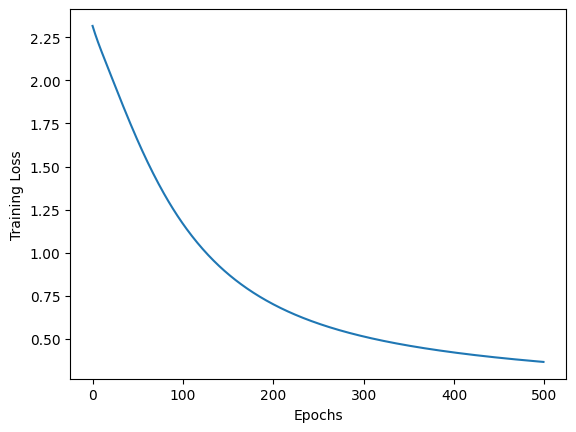

In [ ]:
plt.figure()
plt.plot(loss_history)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.show()